In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import evosax

import json


In [3]:
import xylo
import xylo.types as t
import xylo.woods
import xylo.cut

import xylo.opt

import xylo.tuning
import xylo.database
import xylo.just

In [ ]:
layout = xylo.just.diamond_11_partch
bar_thick = xylo.types.BarProps(width = 0.050, min_depth=0.002, depth=0.010, length = 0.500, elements = 10)
bar_thin = bar_thick._replace(width = 0.032, min_depth=0.002, depth=0.006)
mat = xylo.woods.aluminium_6060T5

tuning = xylo.tuning.yamaha_YX500R

In [5]:
# def mk_geom(note):
#   if True or note[0] >= 'F':
#   # if layout.rows[note] * layout.reference_hz < 1000:
#     bar = bar_thick
#   else:
#     bar = bar_thin
#   return xylo.database.Geometry(width = bar.width * 1000, length = bar.length * 1000, depth = bar.depth * 1000, weight = 1)

# geom0 = { k: mk_geom(k) for k in layout.rows.keys() }
geom0 = xylo.just.diamond_11_partch_geom

def get_db():
  return xylo.database.get(geom0, 'data/db-dia.json')
def with_db(act):
  return xylo.database.with_db(act, geom0, 'data/db-dia.json')

In [6]:
with_db(lambda db: db.clear_loss_all())

In [34]:
init_mean = None
sum_lengths = 0
for num_dims in [2, 3, 5]: # range(3,10):
  options = xylo.opt.Options(num_generations = 10, strategy = evosax.OpenES(popsize = 1000, num_dims = num_dims), absolute_tolerance = 1e-5)

  for note in layout.rows.keys():
    db = get_db()
    match db.get_best_for_dims(note, num_dims):
      case None:
        pass
      case e:
        init_mean = e

    options_ = options._replace(init_mean = init_mean)
    # options_ = options

    bar = db.get_bar(note, elements = 100)
    # bar = bar_default._replace(length = len)
    # bar = t.BarProps(width = 0.) db.get_bar(note)
    # wood = db.get_wood(note)

    freq = layout.reference_hz * layout.rows[note]
    partials = [1.0, 4.0, 10.0]
    weights = [tuning.weight(freq), tuning.weight(freq * partials[1]) * 0.3, tuning.weight(freq * partials[2]) * 0.1]

    print(f"weights {weights}")
    # minimise length of long bars, maximise length of short bars
    weight_len = 0.1 if note[0] >= 'F' else -1
    sol = xylo.opt.optimize_geometry(bar, mat, options_, freq, jnp.array(partials), jnp.array(weights))
    spline = sol.best_member

    with_db(lambda db: db.set_best_for_dims(note, num_dims, sol.best_member.tolist(), sol.best_fitness.tolist()))

    init_mean = sol.best_member

    # spline, len = init_mean[0:-1], init_mean[-1]
    spline, len = init_mean, 1
    barx = bar._replace(length = bar.length * len)
    section = xylo.cut.spline(barx, spline)
    swp = xylo.sweep.sweep(mat, barx, section, t.sweep_default)

    sum_lengths += barx.length

    print(note, freq)
    print("---------------")
    print(swp.harmonics / freq, barx.length, init_mean)
    print("")

print("total length: ", sum_lengths)

weights [1.0, 0.19127999999999998, 0.0]
iteration 0
[0.40788918 0.36063487] 0.00045827343
[ 2155.91706085  8605.38052438 16229.23536846] [0.99996153 3.99136388 7.52747466] 0.119
A1 2156.0
---------------
[0.99996153 3.99136388 7.52747466] 0.119 [0.40788918 0.36063487]

weights [1.0, 0.23831999999999998, 0.0]
iteration 0
[0.37056904 0.21020595] 0.0005625418
[ 1763.53189872  7064.35555921 12277.37180403] [0.99973464 4.00473671 6.95996134] 0.137
B1 1764.0
---------------
[0.99973464 4.00473671 6.95996134] 0.137 [0.37056904 0.21020595]

weights [1.0, 0.24302399999999996, 0.0]
iteration 0
[0.41309413 0.35717762] 0.000529609
[ 1724.69515919  6884.86203868 13043.6909505 ] [0.99993922 3.99168717 7.56243678] 0.134
B2 1724.8000000000002
---------------
[0.99993922 3.99168717 7.56243678] 0.134 [0.41309413 0.35717762]

weights [1.0, 0.28536, 0.0128]
iteration 0
[0.41523315 0.37275471] 0.0036103372
[ 1371.13811675  5486.01177172 10570.97520733] [0.99937181 3.99855085 7.70479243] 0.15
C1 1372.0
----

[0.2938897314397248, 0.4579172720263112, 0.3187517899783154]
I3 0.26
[1.00004471 3.99960596 8.69758408] 427.6363636363636


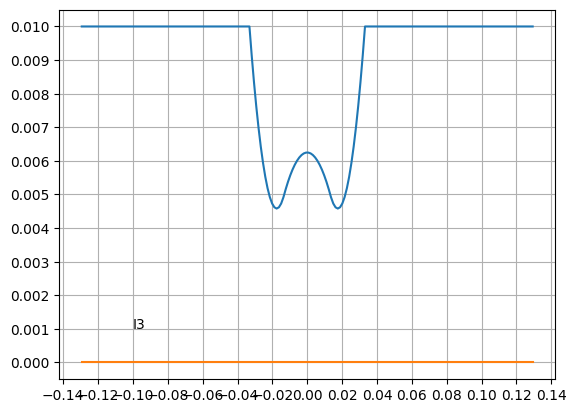

In [94]:
import matplotlib.ticker as plticker
for note in ['I3']: # layout.rows.keys():
  bar = db.get_bar(note, elements = 200)
  fundamental = layout.reference_hz * layout.rows[note]
  len_mul = 0.5
  params = db.get_best_for_dims(note, 3)
  # params = db.get_best(note)['coeff']
  spline, len = params, 1
  print(params)

  section = xylo.cut.spline(bar._replace(length = bar.length * len), jnp.array(spline))
  section.plot(to_scale = False)
  print(note, bar.length)
  swp = xylo.sweep.sweep(mat, bar, section, t.sweep_default)
  print(swp.harmonics / fundamental, fundamental)
  plt.grid()
  ax = plt.gca()
  locx = plticker.MultipleLocator(base=0.02)
  locy = plticker.MultipleLocator(base=0.001)
  ax.xaxis.set_major_locator(locx)
  ax.yaxis.set_major_locator(locy)
  plt.text(-0.1, 0.001, note)
  # plt.gca()

In [37]:
# geom0 = xylo.just.diamond_11_partch_geom
# for k, v in layout.rows.items():
#   print(k, geom0[k].length, geom0[k].width, v * layout.reference_hz)